In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Synaptic Current

## A

In [2]:
def membrane_voltage(v_m1, g, i_syn_func,  params):      
    return (-v_m1 + params['Em'] - params['Rm']*i_syn_func(g, v_m1, params) + params['Rm'] *params['Ie'])/params['tau_m']

In [3]:
def membrane_x(x_m1, t, params):
    ret_val = - x_m1 / params['tau_syn']
    
    if np.abs(t - params['t_spike'])< 0.5 * params['del_t']:
        ret_val += params['g_star']/params['del_t']        
    return ret_val

In [4]:
def synaptic_conductance(g_syn_m1, x, t, params):
    g = (x - g_syn_m1)/params['tau_syn'] 
    return  g

In [5]:
def synaptic_current(g_syn, v, params):
    return g_syn*(v - params['E_syn'])

In [6]:
def membrance_current(v, params):
    return (v - params['Em'])/params['Rm']

In [7]:
def membrane_euler(v_func, g_func, x_func, i_syn_func, params, init_values):
    t = np.arange(0, params['max_t'], step=params['del_t'])
    
    v_res = np.zeros_like(t)
    g_res = np.zeros_like(t)
    x_res = np.zeros_like(t)
    
    v_res[0] = init_values['v0']
    g_res[0] = init_values['g0']
    x_res[0] = init_values['x0']

    for i in range(1, t.shape[0]):
        x_res[i] = x_res[i-1] +  params['del_t'] * x_func(x_m1=x_res[i-1], t=t[i], params=params)
        g_res[i] = g_res[i-1] +  params['del_t'] * g_func(g_syn_m1=g_res[i-1], x=x_res[i], t=t[i], params=params)
        v_res[i] = v_res[i-1] +  params['del_t'] * v_func(v_m1=v_res[i-1], g=g_res[i], i_syn_func=i_syn_func,  params=params)
    return v_res, g_res, t

In [8]:
params = {}
params['tau_syn'] = 10e-3
params['tau_m'] = 10e-3
params['Rm'] = 1e7
params['g_star'] = 30e-9
params['Em'] = -80e-3
params['Ie'] = 0

params['E_syn'] = 0

params['t_spike'] = 0.01
params['del_t'] = 1e-4
params['max_t'] = params['t_spike'] *20

In [9]:
init_values = {}
init_values['v0'] = params['Em']
init_values['g0'] = 0
init_values['x0'] = 0

In [10]:
v_res, g_res, t =membrane_euler(membrane_voltage, synaptic_conductance, membrane_x, synaptic_current, params, init_values)
i_syn = synaptic_current(g_res, v_res, params)
i_mem = membrance_current(v_res, params)

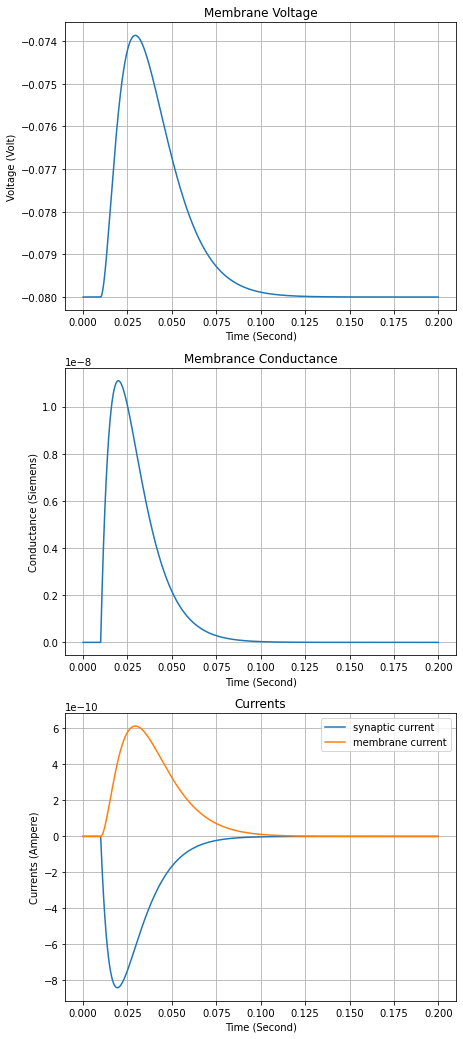

In [11]:
plt.figure(figsize=(7, 18))

plt.subplot(311)
plt.plot(t, v_res)
plt.title('Membrane Voltage')
plt.xlabel('Time (Second)')
plt.ylabel('Voltage (Volt)')
plt.grid()

plt.subplot(312)
plt.plot(t, g_res)
plt.title('Membrance Conductance')
plt.xlabel('Time (Second)')
plt.ylabel('Conductance (Siemens)')
plt.grid()

plt.subplot(313)
plt.plot(t, i_syn, label='synaptic current')
plt.plot(t, i_mem, label='membrane current')
plt.title('Currents')
plt.xlabel('Time (Second)')
plt.ylabel('Currents (Ampere)')
plt.legend()
plt.grid()

plt.show()

In [12]:
max_conductance = float(np.max(g_res))
print('maximum membrane conductance = {} S'.format(max_conductance))

maximum membrane conductance = 1.1091889129491808e-08 S


## B

In [13]:
def shunting_inhibition_current(g_syn, v, params):
    return g_syn*(v - params['E_syn']) + params['g_exc']*(v - params['E_exc']) + params['g_inh']*(v - params['E_inh'])

In [14]:
params['g_exc'] = 50e-9
params['g_inh'] = 200e-9

params['E_exc'] = 0
params['E_inh'] = -100e-3

In [15]:
v_res_s, g_res_s, t =membrane_euler(membrane_voltage, synaptic_conductance, membrane_x, shunting_inhibition_current, params, init_values)
i_syn_s = synaptic_current(g_res_s, v_res_s, params)
i_mem_s = membrance_current(v_res_s, params)

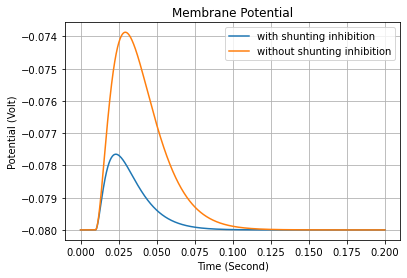

In [16]:
plt.plot(t, v_res_s, label='with shunting inhibition')
plt.plot(t, v_res, label='without shunting inhibition')
plt.title('Membrane Potential')
plt.xlabel('Time (Second)')
plt.ylabel('Potential (Volt)')
plt.legend()
plt.grid()

## Discussion

Shunting inhibition reduce the peak of the membrane potential. This is caused by the inhibitory inputs would try to balanced out the exhibitory inputs. This result in a smaller peak

# 2. Integrate and Fire Neuron

In [17]:
def membrane_euler_w_reset(v_func, g_func, x_func, i_syn_func, params, init_values):
    t = np.arange(0, params['max_t'], step=params['del_t'])
    
    v_res = np.zeros_like(t)
    g_res = np.zeros_like(t)
    x_res = np.zeros_like(t)
    
    v_res[0] = init_values['v0']
    g_res[0] = init_values['g0']
    x_res[0] = init_values['x0']

    for i in range(1, t.shape[0]):
        x_res[i] = x_res[i-1] +  params['del_t'] * x_func(x_m1=x_res[i-1], t=t[i], params=params)
        g_res[i] = g_res[i-1] +  params['del_t'] * g_func(g_syn_m1=g_res[i-1], x=x_res[i], t=t[i], params=params)
        v_res[i] = v_res[i-1] +  params['del_t'] * v_func(v_m1=v_res[i-1], g=g_res[i], i_syn_func=i_syn_func,  params=params)
        if v_res[i] > params['v_thr']:            
            v_res[i] = params['v_reset']
    return v_res, g_res, t

In [18]:
def constant_synaptic_current(g_syn, v, params):
    return 0

In [19]:
def compute_isi(series, t):
    ts = np.argwhere(series == np.max(series)) 
    
    t_spike = t[ts].ravel()
    isi = np.mean(np.diff(t_spike))
    return isi

In [20]:
def compute_firing_rate(series, t):
    
    num_spikes = np.argwhere(series == np.max(series)).ravel().shape[0]
    return num_spikes / (np.max(t) -np.min(t))

In [21]:
params = {}

params['tau_syn'] = 10e-3
params['tau_m'] = 10e-3
params['Rm'] = 1e7
params['g_star'] = 30e-9
params['Em'] = -80e-3
params['Ie'] = 3e-9

params['E_syn'] = 0
params['v_thr'] = -54e-3
params['v_reset'] =params['Em']

params['t_spike'] = 100e-3
params['del_t'] = 1e-4

### t max = 100 ms

In [22]:
params['max_t'] = 100e-3

In [23]:
v_res, _, t =membrane_euler_w_reset(membrane_voltage, synaptic_conductance, membrane_x, constant_synaptic_current, params, init_values)

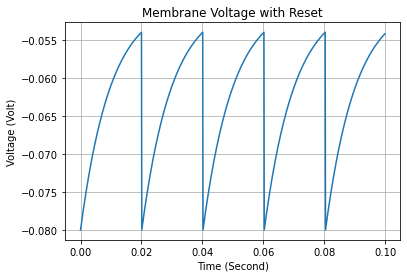

In [24]:
plt.plot(t, v_res)
plt.title('Membrane Voltage with Reset')
plt.xlabel('Time (Second)')
plt.ylabel('Voltage (Volt)')
plt.grid()

plt.show()

In [25]:
compute_isi(v_res, t)

0.020100000000000003

In [26]:
compute_firing_rate(v_res, t)

40.04004004004004

### t max = 500 ms

In [27]:
params['max_t'] = 500e-3

In [28]:
v_res, _, t =membrane_euler_w_reset(membrane_voltage, synaptic_conductance, membrane_x, constant_synaptic_current, params, init_values)

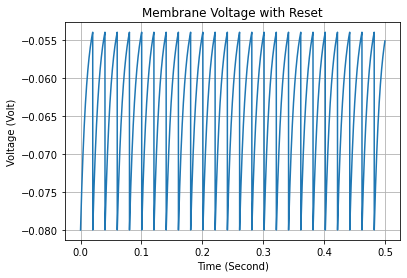

In [29]:
plt.plot(t, v_res)
plt.title('Membrane Voltage with Reset')
plt.xlabel('Time (Second)')
plt.ylabel('Voltage (Volt)')
plt.grid()

plt.show()

In [30]:
compute_isi(v_res, t)

0.020100000000000003

In [31]:
compute_firing_rate(v_res, t)

48.00960192038408

### Discussion

The firing should be 1/ISI. However, when using smaller time window, the formula does not fit since there is counting error.

The bigger the time window, the smaller the firing rate calculation error. Larger time window would let more peaks. In contrast, smaller time windows increase the probability of signal not reaching peaks at the end of the period, therefore it becomes uncountable.

## C

In [32]:
def theoretical_firing_rate(params, ie):
    nom = params['Rm']*ie + params['Em'] - params['v_reset']
    denom = params['Rm']*ie + params['Em'] - params['v_thr']
    
    ret_mat =  1. / (params['tau_m'] * np.log(nom/denom))
    
    return np.nan_to_num(ret_mat, nan=0)

In [33]:
ies = np.linspace(1e-9,5e-9,100)

In [34]:
params['max_t'] = 100e-3

In [35]:
fr_theoretical = theoretical_firing_rate(params, ies)

<ipython-input-32-bc74abbe4ba7>:5: RuntimeWarning: invalid value encountered in log
  ret_mat =  1. / (params['tau_m'] * np.log(nom/denom))


In [36]:
fr_sim = []
params['max_t'] = 250e-3
for i in range(ies.shape[0]):
    params['Ie'] = ies[i]
    v_res, _, t = membrane_euler_w_reset(membrane_voltage, synaptic_conductance, membrane_x, constant_synaptic_current, params, init_values)
    fr = compute_firing_rate(v_res, t)
    fr_sim.append(fr)

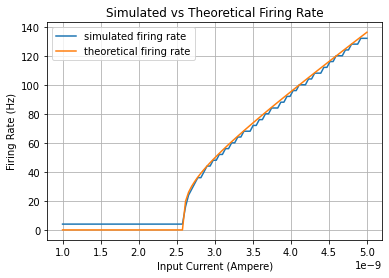

In [37]:
plt.plot(ies, fr_sim, label='simulated firing rate')
plt.plot(ies, fr_theoretical, label='theoretical firing rate')

plt.xlabel('Input Current (Ampere)')
plt.ylabel('Firing Rate (Hz)')

plt.title('Simulated vs Theoretical Firing Rate')

plt.legend()

plt.grid()
plt.show()

### Discussion

The graph seems to get higher along with the input current. However, in reality, the firing rate should be asymptotic to a certain value. It is impossible for a neuron to fire in a really high firing rate. In addition, neuron also cannot take large input current since it would destroy the neuron itself.

# 3. Synaptically coupled IF neurons

## A

In [38]:
def two_membranes(v_func, g_func, x_func, i_syn_func, params, init_values):
    t = np.arange(0, params['max_t'], step=params['del_t'])
    
    v1_res = np.zeros_like(t)
    g1_res = np.zeros_like(t)
    x1_res = np.zeros_like(t)
    
    v2_res = np.zeros_like(t)
    g2_res = np.zeros_like(t)
    x2_res = np.zeros_like(t)
    
    v1_res[0] = init_values['v0']
    g1_res[0] = init_values['g0']
    x1_res[0] = init_values['x0']
    
    v2_res[0] = init_values['v0']
    g2_res[0] = init_values['g0']
    x2_res[0] = init_values['x0']
    
    params1 = params.copy()
    params2 = params.copy()
    
    params1['t_spike'] = params['del_t'] #x(0) = init state, t(del_t) -> 1st spike
    params2['t_spike'] = np.max(t)
    
    for i in range(1, t.shape[0]-1):
        x1_res[i] = x1_res[i-1] +  params['del_t'] * x_func(x_m1=x1_res[i-1], t=t[i], params=params1)
        g1_res[i] = g1_res[i-1] +  params['del_t'] * g_func(g_syn_m1=g1_res[i-1], x=x1_res[i], t=t[i], params=params1)
        v1_res[i] = v1_res[i-1] +  params['del_t'] * v_func(v_m1=v1_res[i-1], g=g1_res[i], i_syn_func=i_syn_func,  params=params1)
        if v1_res[i] > params['v_thr']:            
            v1_res[i] = params['v_reset']
            params2['t_spike'] = t[i]
            #print('spike 1')
        
        x2_res[i] = x2_res[i-1] +  params['del_t'] * x_func(x_m1=x2_res[i-1], t=t[i], params=params2)
        g2_res[i] = g2_res[i-1] +  params['del_t'] * g_func(g_syn_m1=g2_res[i-1], x=x2_res[i], t=t[i], params=params2)
        v2_res[i] = v2_res[i-1] +  params['del_t'] * v_func(v_m1=v2_res[i-1], g=g2_res[i], i_syn_func=i_syn_func,  params=params2)
        if v2_res[i] > params['v_thr']:            
            v2_res[i] = params['v_reset']
            params1['t_spike'] = t[i+1]        
            #print('spike 2')
    return v1_res[:-2], v2_res[:-2], t[:-2]

In [39]:
params = {}

params['tau_syn'] = 10e-3
params['tau_m'] = 10e-3
params['Rm'] = 1e7
params['g_star'] = 30e-9
params['Em'] = -70e-3
params['Ie'] = 3.5e-9#3.5e-9

params['E_syn'] = 0
params['v_thr'] = -54e-3
params['v_reset'] = -80e-3

params['t_spike'] = 1e-3
params['del_t'] = 1e-4
params['max_t'] = 200e-3

In [40]:
init_values = {}
init_values['v0'] = params['Em']
init_values['g0'] = 0
init_values['x0'] = 0

## B

In [41]:
v1_res, v2_res, t =two_membranes(membrane_voltage, synaptic_conductance, membrane_x, synaptic_current, params, init_values)

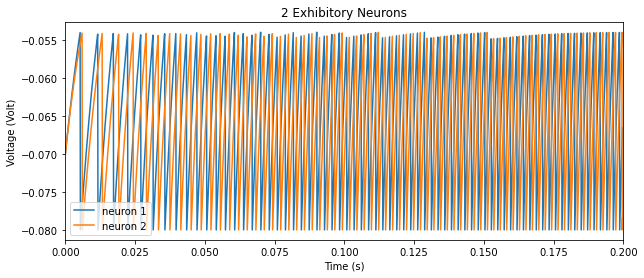

In [42]:
plt.figure(figsize=(10,4))
plt.plot(t, v1_res, label='neuron 1')
plt.plot(t, v2_res,label='neuron 2')

plt.xlim(0, params['max_t'])
plt.title('2 Exhibitory Neurons')
plt.ylabel('Voltage (Volt)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [43]:
params = {}

params['tau_syn'] = 10e-3
params['tau_m'] = 10e-3
params['Rm'] = 1e7
params['g_star'] = 30e-9
params['Em'] = -70e-3
params['Ie'] = 3.5e-9#3.5e-9

params['E_syn'] = -100e-3
params['v_thr'] = -54e-3
params['v_reset'] = -80e-3

params['t_spike'] = 1e-3
params['del_t'] = 1e-4
params['max_t'] = 200e-3

In [44]:
init_values = {}
init_values['v0'] = params['Em']
init_values['g0'] = 0
init_values['x0'] = 0

In [45]:
v1_res, v2_res, t =two_membranes(membrane_voltage, synaptic_conductance, membrane_x, synaptic_current, params, init_values)

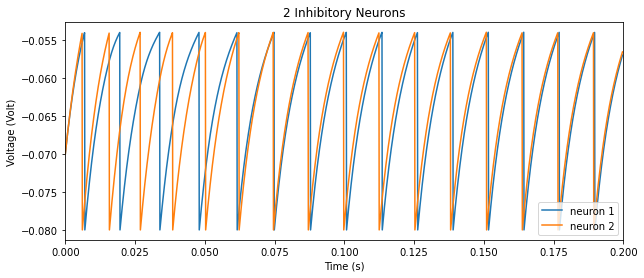

In [46]:
plt.figure(figsize=(10,4))
plt.plot(t, v1_res, label='neuron 1')
plt.plot(t, v2_res,label='neuron 2')

plt.xlim(0, params['max_t'])
plt.title('2 Inhibitory Neurons')
plt.ylabel('Voltage (Volt)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

### Discussion

It seems that in the case of network of exhibitory neurons, both neuron are increasing their firing rate. In contrast, the inhibitory neurons seems to get their firing rate smaller. 

In addition, in the case of exhibitory neurons, it seems that the neurons are firing not in synchrony. On the other hand, the inhibitory neurons seem to synchronize adter some times.

In [47]:
params = {}

params['tau_syn'] = 2*10e-3
params['tau_m'] = 10e-3
params['Rm'] = 1e7
params['g_star'] = 30e-9
params['Em'] = 0
params['Ie'] = 3e-9#3.5e-9

params['E_syn'] = 0
params['v_thr'] = -54e-3
params['v_reset'] = -80e-3

params['t_spike'] = 1e-3
params['del_t'] = 1e-4
params['max_t'] = 200e-3

In [48]:
init_values = {}
init_values['v0'] = params['Em']
init_values['g0'] = 0
init_values['x0'] = 0

In [49]:
v1_res, v2_res, t =two_membranes(membrane_voltage, synaptic_conductance, membrane_x, synaptic_current, params, init_values)

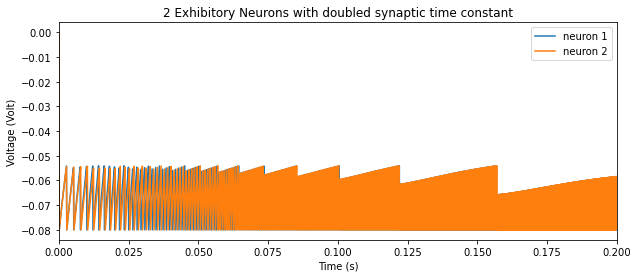

In [50]:
plt.figure(figsize=(10,4))
plt.plot(t, v1_res, label='neuron 1')
plt.plot(t, v2_res,label='neuron 2')

plt.xlim(0, params['max_t'])
plt.title('2 Exhibitory Neurons with doubled synaptic time constant')
plt.ylabel('Voltage (Volt)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

In [51]:
params = {}

params['tau_syn'] = 10e-3
params['tau_m'] = 10e-3
params['Rm'] = 1e7
params['g_star'] = 2*30e-9
params['Em'] = 0
params['Ie'] = 3e-9#3.5e-9

params['E_syn'] = 0
params['v_thr'] = -54e-3
params['v_reset'] = -80e-3

params['t_spike'] = 1e-3
params['del_t'] = 1e-4
params['max_t'] = 200e-3

In [52]:
init_values = {}
init_values['v0'] = params['Em']
init_values['g0'] = 0
init_values['x0'] = 0

In [53]:
v1_res, v2_res, t =two_membranes(membrane_voltage, synaptic_conductance, membrane_x, synaptic_current, params, init_values)

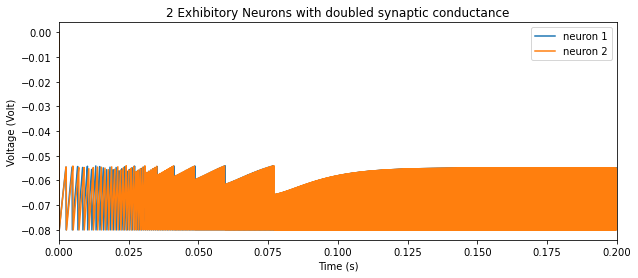

In [54]:
plt.figure(figsize=(10,4))
plt.plot(t, v1_res, label='neuron 1')
plt.plot(t, v2_res,label='neuron 2')

plt.xlim(0, params['max_t'])
plt.title('2 Exhibitory Neurons with doubled synaptic conductance')
plt.ylabel('Voltage (Volt)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

### Discussion

it seems that when the parameters were changed, the voltage in the 2 neurons fluctuates in the beginning. it also can be seen that the grequency of the firing rate is significantly higher. 